# Predicting no-show patients at a Dental Practice

## Introduction

### Goal
To document steps used to create a machine learning algorithm that predicts patient attendance.

### Steps

1) Feature Engineering

2) Building ML model

3) Hyperparameter Tuning

4) Visualizing model output





## 1) Automatic Feature Creation using featuretools

In [1]:
import featuretools as ft
import featuretools.variable_types as vtypes
import pandas as pd
import os
import multiprocess as mp
import pickle

# Load the model from disk
weather = pickle.load(open('data/weather2018.pkl', 'rb'))
weather = pd.DataFrame(weather)

#read current working directory
##assume running notebook from No_show_patience directory
cwd = os.getcwd()


#import and load data
full_dataset = pd.read_pickle(cwd + "/data/preFT2018_deid.pkl")
#use below code at experimentation stage to build new features on a small dataset.
#full_dataset = full_dataset.iloc[:5,:]

full_dataset.AppointmentDate = (pd.to_datetime(full_dataset.AppointmentDate) + 
                                (pd.Timedelta(days = 1) - pd.Timedelta(seconds = 1)) * (full_dataset.noshow))





In [4]:
keep = ['PatientId', 'AppointmentDate', 'newbie',
                  'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
                  'PatientEmail', 'GuarantorEmail', 'PatientPhone1', 
                  'patientEmailDomain', 'guarantorEmailDomain', 'patientPhone1AreaCode',
                  'insurance','provider', 'source','procedure', 'weekday', 'apptType', 
                  "newpatientfile", "Age_npf", "Patient", 'AppointmentId']
full_dataset=full_dataset[keep]
full_dataset.iloc[0:9,:].to_csv(cwd + "/data/head.csv")
full_dataset.sample(n = 20).to_csv(cwd + "/data/random20.csv")


In [5]:

# x = full_dataset['AppointmentDate'].dt.round('60min')
# full_dataset['datetime'] = pd.to_datetime(x)
# weather['datetime'] = pd.to_datetime(weather['time'],unit='s').dt.round('60min')
# full_dataset = full_dataset.merge(weather,on='datetime', how="left")

In [7]:
variable_types = {'PatientId':vtypes.Numeric, 'newbie':vtypes.Boolean,'insuranceDummy':vtypes.Boolean, 
                  'guarantorIsPatient':vtypes.Boolean, 'loyalty':vtypes.Numeric, 'noshow':vtypes.Boolean, 
                  'PatientEmail':vtypes.EmailAddress,'GuarantorEmail':vtypes.EmailAddress,
                  'PatientPhone1':vtypes.PhoneNumber, 'patientEmailDomain':vtypes.Categorical,
                  'guarantorEmailDomain':vtypes.Categorical, 'patientPhone1AreaCode':vtypes.Categorical, 
                  'insurance':vtypes.Categorical, 'provider':vtypes.Categorical, 
                  'source':vtypes.Categorical, 'procedure':vtypes.Categorical,
                  'weekday':vtypes.Categorical, 'apptType':vtypes.Categorical,
                  "newpatientfile":vtypes.Ordinal, "Age_npf":vtypes.Numeric, "Patient":vtypes.Text#,
#                   'summary':vtypes.Text, 'icon':vtypes.Text, 'precipIntensity':vtypes.Numeric, 
#                   'temperature':vtypes.Numeric,'apparentTemperature':vtypes.Numeric, 'dewPoint':vtypes.Numeric,
#                   'humidity':vtypes.Numeric, 'pressure':vtypes.Numeric, 'windSpeed':vtypes.Numeric,
#                   'windGust':vtypes.Numeric, 'windBearing':vtypes.Numeric, 'cloudCover':vtypes.Numeric,
                 }
variable_list = (['PatientId', 'AppointmentDate', 'newbie',
                  'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
                  'PatientEmail', 'GuarantorEmail', 'PatientPhone1', 
                  'patientEmailDomain', 'guarantorEmailDomain', 'patientPhone1AreaCode',
                  'insurance','provider', 'source','procedure', 'weekday', 'apptType', 
                  "newpatientfile", "Age_npf", "Patient", 'AppointmentId'#,
#                   'summary', 'icon',
#                   'precipIntensity', 'temperature',
#                   'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed',
#                   'windGust', 'windBearing', 'cloudCover'
                 ])

# Make an entity named 'appointments' which stores dataset metadata with the dataframe
es = ft.EntitySet('Appointments')
es = es.entity_from_dataframe(entity_id="appointments",
                              dataframe=full_dataset[variable_list],
                              index='AppointmentId',
                              time_index='AppointmentDate',
                              variable_types=variable_types)
es['appointments']

# Make patients, weekdays, emails and insurances entities

es.normalize_entity(base_entity_id='appointments', new_entity_id='patients', index='PatientId', 
                    additional_variables = ['Patient', 'PatientEmail', 'GuarantorEmail', 'PatientPhone1',
                                            'newpatientfile', 'Age_npf'], make_time_index=True)
# 'PatientEmail', 'GuarantorEmail', 'PatientPhone1'
es.normalize_entity('appointments', 'patientemails', 'patientEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'guarantoremails', 'guarantorEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'patientPhones', 'patientPhone1AreaCode',make_time_index=True)
es.normalize_entity('appointments', 'insurances', 'insurance',make_time_index=True)
es.normalize_entity('appointments', 'providers', 'provider', make_time_index=True)
es.normalize_entity('appointments', 'sources', 'source', make_time_index=True)
es.normalize_entity('appointments', 'procedures', 'procedure', make_time_index=True)
es.normalize_entity('appointments', 'weekdays', 'weekday', make_time_index=True)
es.normalize_entity('appointments', 'apptTypes', 'apptType',make_time_index=True)


Entityset: Appointments
  Entities:
    appointments [Rows: 5471, Columns: 17]
    patients [Rows: 2020, Columns: 8]
    patientemails [Rows: 1, Columns: 2]
    guarantoremails [Rows: 1, Columns: 2]
    patientPhones [Rows: 8, Columns: 2]
    insurances [Rows: 9, Columns: 2]
    providers [Rows: 4, Columns: 2]
    sources [Rows: 6, Columns: 2]
    procedures [Rows: 21, Columns: 2]
    weekdays [Rows: 5, Columns: 2]
    apptTypes [Rows: 3, Columns: 2]
  Relationships:
    appointments.PatientId -> patients.PatientId
    appointments.patientEmailDomain -> patientemails.patientEmailDomain
    appointments.guarantorEmailDomain -> guarantoremails.guarantorEmailDomain
    appointments.patientPhone1AreaCode -> patientPhones.patientPhone1AreaCode
    appointments.insurance -> insurances.insurance
    appointments.provider -> providers.provider
    appointments.source -> sources.source
    appointments.procedure -> procedures.procedure
    appointments.weekday -> weekdays.weekday
    appointmen

In [8]:
print(es)

Entityset: Appointments
  Entities:
    appointments [Rows: 5471, Columns: 29]
    patients [Rows: 2020, Columns: 8]
    patientemails [Rows: 9, Columns: 2]
    guarantoremails [Rows: 8, Columns: 2]
    patientPhones [Rows: 8, Columns: 2]
    insurances [Rows: 9, Columns: 2]
    providers [Rows: 4, Columns: 2]
    sources [Rows: 6, Columns: 2]
    procedures [Rows: 21, Columns: 2]
    weekdays [Rows: 5, Columns: 2]
    apptTypes [Rows: 3, Columns: 2]
  Relationships:
    appointments.PatientId -> patients.PatientId
    appointments.patientEmailDomain -> patientemails.patientEmailDomain
    appointments.guarantorEmailDomain -> guarantoremails.guarantorEmailDomain
    appointments.patientPhone1AreaCode -> patientPhones.patientPhone1AreaCode
    appointments.insurance -> insurances.insurance
    appointments.provider -> providers.provider
    appointments.source -> sources.source
    appointments.procedure -> procedures.procedure
    appointments.weekday -> weekdays.weekday
    appointmen

In [8]:
cutoff_times =  es['appointments'].df[['AppointmentId','AppointmentDate']]
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
            'patientPhone1AreaCode','weekday', 'apptType','source']

X_ft, features = ft.dfs(entityset=es,
                        target_entity='appointments',
                        agg_primitives=['count', 'percent_true', 'num_true', 'trend', 'skew', 'all', 'std',
                                       'max', 'mean', 'min', 'median', 'num_unique'],
                        max_depth=3,
                        trans_primitives=['day', 'month', 'year', 'num_words', 'num_characters'],
                        cutoff_time=cutoff_times,
                        verbose=True,
                        approximate = '3h',
                        #approximate = "1 day",
                        chunk_size=50,
                        n_jobs=mp.cpu_count())

Built 342 features
EntitySet scattered to 4 workers in 12 seconds          
Elapsed: 20:37 | Progress:  95%|█████████▌| Remaining: 01:30  

Task exception was never retrieved
future: <Task finished coro=<BaseTCPConnector.connect() done, defined at /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/distributed/comm/tcp.py:341> exception=CommClosedError('in <distributed.comm.tcp.TCPConnector object at 0x1223d5b50>: ConnectionRefusedError: [Errno 61] Connection refused')>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/distributed/comm/tcp.py", line 348, in connect
    ip, port, max_buffer_size=MAX_BUFFER_SIZE, **kwargs
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/tcpclient.py", line 280, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/tcpclient.py", line 143, in on_connect_done
    stream = future.result()
tornado.iostream.StreamClosedError: Stream is cl

Elapsed: 21:15 | Progress: 100%|██████████| Remaining: 00:00


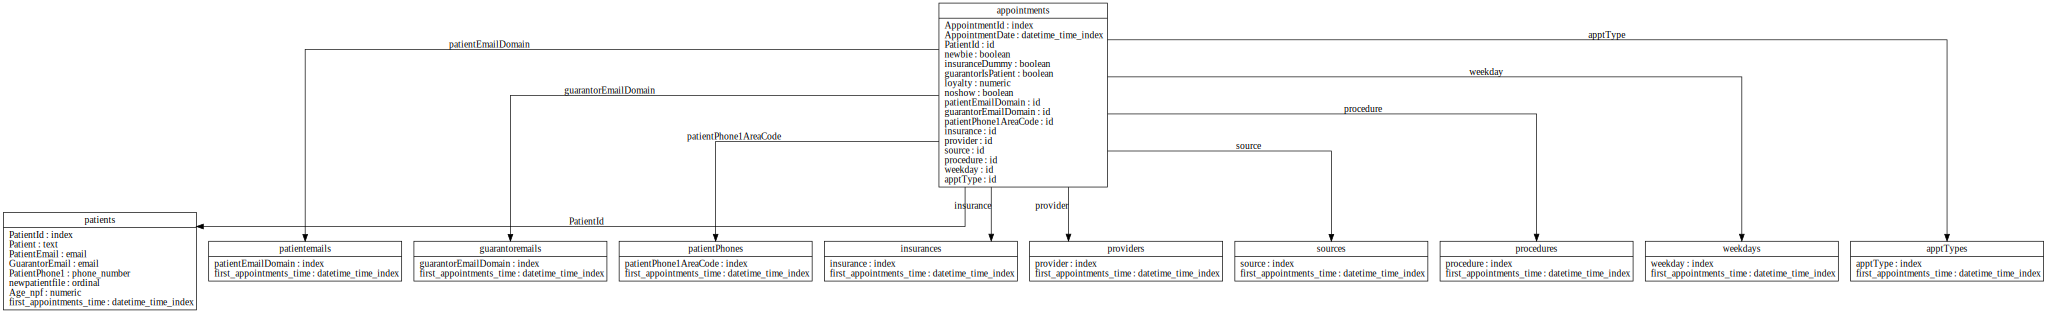

In [10]:
es.plot()

In [19]:
 weather = pickle.load(open('data/weather2018.pkl', 'rb'))
 weather = pd.DataFrame(weather)
 X_ft['datetime'] = pd.to_datetime(full_dataset['AppointmentDate'].dt.round('60min'))
 weather['datetime'] = pd.to_datetime(weather['time'],unit='s').dt.round('60min')
X_ft = X_ft.merge(weather[['temperature','humidity','datetime']],on='datetime', how="left").drop(['datetime'], axis=1)
X_ft["temperature"] = pd.to_numeric(X_ft["temperature"])
X_ft["humidity"] = pd.to_numeric(X_ft["humidity"])
X_ft.head()


,PatientId,newbie,insuranceDummy,guarantorIsPatient,loyalty,noshow,patientEmailDomain,guarantorEmailDomain,patientPhone1AreaCode,insurance,...,apptTypes.NUM_UNIQUE(appointments.insurance),apptTypes.NUM_UNIQUE(appointments.provider),apptTypes.NUM_UNIQUE(appointments.source),apptTypes.NUM_UNIQUE(appointments.procedure),apptTypes.NUM_UNIQUE(appointments.weekday),apptTypes.DAY(first_appointments_time),apptTypes.MONTH(first_appointments_time),apptTypes.YEAR(first_appointments_time),temperature,humidity
0,9608,0,0,True,19,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_ea4,Insurance_others,...,NaN,NaN,NaN,NaN,NaN,2,1,2018,74.89,0.89
1,9393,0,0,True,10,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_ea4,Insurance_others,...,NaN,NaN,NaN,NaN,NaN,2,1,2018,69.44,0.98
2,9200,0,1,True,24,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_others,Insurance_UNITED CONCORDIA,...,NaN,NaN,NaN,NaN,NaN,2,1,2018,55.75,0.97
3,8562,0,0,True,19,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_ea4,Insurance_others,...,2.0,1.0,2.0,1.0,1.0,2,1,2018,24.52,0.81
4,9961,0,0,True,19,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_84f,Insurance_others,...,1.0,2.0,1.0,2.0,1.0,2,1,2018,73.41,0.65


In [18]:
#X_ft = X_ft.drop(["humidity_x",'humidity_y','temperature_y','temperature_x'],axis=1)

## 2) Building ML models

In [6]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
import pandas as pd
import numpy as np
import multiprocess as mp
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
import os

cwd = os.getcwd()

In [12]:
##skip this step if loading in pickle
##choose to drop cat cols
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
           'patientPhone1AreaCode','weekday', 'apptType','source']


##import and load data
full_dataset = pd.concat([X_ft],axis=1).drop(cat_cols,axis=1)

NameError: name 'X_ft' is not defined

In [7]:
#pickle that data set. only do this when you want to replace
#X_ft.drop(cat_cols,axis=1).to_pickle(cwd + "/data/postFT_insight_weather.pkl")
full_dataset = pd.read_pickle(cwd + "/data/postFT_insight_weather.pkl")

In [8]:
##if loading pickle, drop in here
X = full_dataset.drop(['noshow'],axis=1)
y = full_dataset[['noshow']]



In [9]:
X.head()

,PatientId,newbie,insuranceDummy,guarantorIsPatient,loyalty,DAY(AppointmentDate),MONTH(AppointmentDate),YEAR(AppointmentDate),patients.newpatientfile,patients.Age_npf,...,apptTypes.NUM_UNIQUE(appointments.insurance),apptTypes.NUM_UNIQUE(appointments.provider),apptTypes.NUM_UNIQUE(appointments.source),apptTypes.NUM_UNIQUE(appointments.procedure),apptTypes.NUM_UNIQUE(appointments.weekday),apptTypes.DAY(first_appointments_time),apptTypes.MONTH(first_appointments_time),apptTypes.YEAR(first_appointments_time),temperature,humidity
0,9608,0,0,True,19,2,1,2018,201606,NaN,...,NaN,NaN,NaN,NaN,NaN,2,1,2018,74.89,0.89
1,9393,0,0,True,10,2,1,2018,201703,54.0,...,NaN,NaN,NaN,NaN,NaN,2,1,2018,69.44,0.98
2,9200,0,1,True,24,2,1,2018,201611,35.0,...,NaN,NaN,NaN,NaN,NaN,2,1,2018,55.75,0.97
3,8562,0,0,True,19,2,1,2018,201606,NaN,...,2.0,1.0,2.0,1.0,1.0,2,1,2018,24.52,0.81
4,9961,0,0,True,19,2,1,2018,201606,NaN,...,1.0,2.0,1.0,2.0,1.0,2,1,2018,73.41,0.65


In [13]:
#split 2018 data into training and test sets, setting a seed for replication purposes
cutoff_month = 8
X_train, X_test, y_train, y_test = (X[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    X[X['MONTH(AppointmentDate)']>cutoff_month],
                                    y[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    y[X['MONTH(AppointmentDate)']>cutoff_month])


# Explicitly impute values for missing fields for RF and Log
X_train, X_test = X_train.fillna(X_train.mean()), X_test.fillna(X_test.mean())
X_train, X_test = X_train.fillna(0), X_test.fillna(0)



In [14]:
#logistic regression model
model_log = LogisticRegression(solver="liblinear", C=0.5, random_state=1).fit(X_train,y_train) ## train on data
y_pred_model_log = model_log.predict_proba(X_test) #predict on test set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
from sklearn.ensemble import RandomForestClassifier
#random forest model
model_rf = RandomForestClassifier(n_estimators=1000, random_state=1).fit(X_train,y_train) ## train on data
y_pred_model_rf = model_rf.predict_proba(X_test) #predict on test set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
##XGBoost
from xgboost import XGBClassifier, plot_importance

#XGB - automatically deals with missing values during training
model_xgb = (XGBClassifier(n_estimators=50, max_depth = 3, eta = 0.1, subsample = 0.6, 
                           n_thread = 4, random_state=1, alpha = 0,
                           tree_method = 'hist').fit(X_train,y_train.values.ravel()))
y_pred_model_xgb = model_xgb.predict_proba(X_test)

In [17]:
print("The AUC score of the Log Reg model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_log)[1]),2)))
print("The AUC score of the RF model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_rf)[1]),2)))
print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))


The AUC score of the Log Reg model is: 0.6
The AUC score of the RF model is: 0.62
The AUC score of the XGB model is: 0.66


### 3) Hyperparameter Tuning

In [ ]:
score = 'roc_auc' #originally also roc_auc

#### max depth

In [ ]:
#max depth
param_test2 = {'max_depth':range(5,45,10)}

gsearch2 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 5, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test2, scoring=score, iid=False)

gsearch2.fit(X_train,y_train.values.ravel())
gsearch2.best_params_, gsearch2.best_score_



In [ ]:
#max depth fine tune
param_test3 = {'max_depth':[1,2,3,4,5]}

gsearch3 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 5, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test3, scoring=score, iid=False)

gsearch3.fit(X_train,y_train.values.ravel())
gsearch3.best_params_, gsearch3.best_score_



#### max estimators

In [ ]:
#n_estimators
param_test4 = {'n_estimators':range(200,1400,200)}

gsearch4 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 15, eta = 0.15, subsample = 0.05,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test4, scoring=score, iid=False)

gsearch4.fit(X_train,y_train.values.ravel())
gsearch4.best_params_, gsearch4.best_score_


In [ ]:
#n_estimators
# param_test4 = {'n_estimators':[6,12,25, 50, 100,200]}

# gsearch4 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.15076, subsample = 0.62141,
#                                                   n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
#                         cv=5, param_grid = param_test4, scoring=score, iid=False)

# gsearch4.fit(X_train,y_train.values.ravel())
# gsearch4.best_params_, gsearch4.best_score_

#### eta

In [ ]:
#eta
param_test5 = {'eta':[i/20.0 for i in range(1,8)]}

gsearch5 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test5, scoring=score, iid=False)

gsearch5.fit(X_train,y_train.values.ravel())
gsearch5.best_params_, gsearch5.best_score_


#### subsample

In [ ]:
#subsample
param_test6 = {'subsample':[i/10.0 for i in range(1,9,2)]}

gsearch6 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test6, scoring=score, iid=False)

gsearch6.fit(X_train,y_train.values.ravel())
gsearch6.best_params_, gsearch6.best_score_


#### alpha 

In [ ]:
#alpha rate
param_test1 = {'alpha':[0, 1e-2, 0.1, 1, 10, 100, 1000]}

gsearch1 = GridSearchCV(estimator = XGBClassifier(n_estimators=800,max_depth = 3, eta = 0.05, subsample = 0.5,
                                                  n_thread = 4, random_state=1, alpha = 0.5,tree_method = 'hist'),
                        cv=5, param_grid = param_test1, scoring=score, iid=False)

gsearch1.fit(X_train,y_train.values.ravel())
gsearch1.best_params_, gsearch1.best_score_
##alpha of 0 is best

#### gamma

In [438]:
import numpy as np
#gamma rate
param_test7 = {'gamma':[0.0, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]}

gsearch7 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist'),
                        cv=5, param_grid = param_test7, scoring=score, iid=False)

gsearch7.fit(X_train,y_train.values.ravel())
gsearch7.best_params_, gsearch7.best_score_


({'gamma': 16.0}, 0.46834822660837644)

In [439]:
#gamma rate
param_test7 = {'gamma':[16.0, 32.0]}
gsearch7 = GridSearchCV(estimator = XGBClassifier(n_estimators=1400, max_depth = 3, eta = 0.05, subsample = 0.7, 
                           n_thread = 4, random_state=1, alpha = 0,gamma =25,
                           tree_method = 'hist'),
                        cv=5, param_grid = param_test7, scoring=score, iid=False)

gsearch7.fit(X_train,y_train.values.ravel())
gsearch7.best_params_, gsearch7.best_score_

({'gamma': 16.0}, 0.46834822660837644)

#### all together

In [ ]:
param_test8 = {'gamma':[np.arange(0, 10, 0.5)],
               'max_depth':[range(5,30,5)],
               'n_estimators':[range(200,2000,200)],
               'eta':[i/20.0 for i in range(1,6)],
               'subsample':[i/10.0 for i in range(1,9,2)],
              }
eval_set = [X_test, y_test.values.ravel()]
gsearch8 = GridSearchCV(estimator = XGBClassifier(n_estimators=1400,max_depth = , eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist',eval_metric='auc', eval_set=eval_set,early_stopping_rounds=10),
                        cv=5, param_grid = param_test8, scoring='roc_auc', iid=False)


gsearch8.fit(X_train,y_train.values.ravel())
gsearch8.best_params_, gsearch8.best_score_
#parameters for roc_auc without weather
# ({'eta': 0.05,
#   'gamma': 0.0,
#   'max_depth': 1,
#   'n_estimators': 25,
#   'subsample': 0.5},
#  0.582821084090225)


In [35]:
##XGBoost with updated stuff
from xgboost import XGBClassifier, plot_importance

eval_set = [(X_train, y_train.values.ravel()), (X_test, y_test.values.ravel())]

#XGB - automatically deals with missing values during training
model_xgb_PT = XGBClassifier(n_estimators=1400, max_depth = 5, eta = 0.05, subsample = 0.7, 
                           n_thread = 4, random_state=1, alpha = 0,gamma =10,objective= 'binary:logistic',
                           tree_method = 'hist').fit(X_train, y_train.values.ravel(), 
                                                     eval_metric=["error", "logloss","auc"], eval_set=eval_set,early_stopping_rounds=10, verbose=False)
y_pred_model_xgb_PT = model_xgb_PT.predict_proba(X_test)
print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1]),2)))


The AUC score of the XGB model is: 0.7


### 4) Visualizing Model 


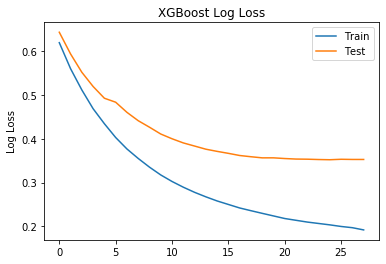

In [37]:
from matplotlib import pyplot

# retrieve performance metrics
results = model_xgb_PT.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


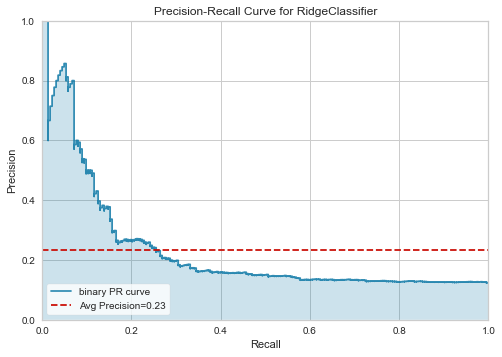

In [38]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.datasets import load_spam

# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(RidgeClassifier())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

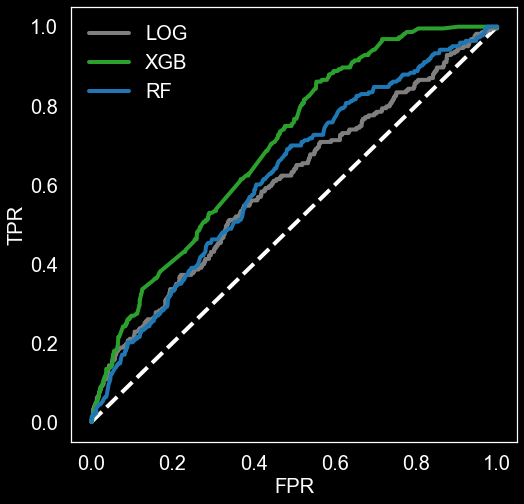

In [81]:
##comparing LOG, XGB, RF

import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

##tableau colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

plt.style.use('dark_background') # this turns the whole figure (and following figures) into dark mode

fig, ax = pyplot.subplots(figsize=(8,8))
# ax.spines["top"].set_visible(False)    
# ax.spines["bottom"].set_visible(False)    
# ax.spines["right"].set_visible(False)    
# ax.spines["left"].set_visible(False)    

# Hide grid lines
ax.grid(False)

##calculate false positive and true positive rates
fpr, tpr,_=roc_curve(y_test,pd.DataFrame(y_pred_model_log)[1],drop_intermediate=False)
fpr_2, tpr_2,_=roc_curve(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1],drop_intermediate=False)
fpr_3, tpr_3,_=roc_curve(y_test,pd.DataFrame(y_pred_model_rf)[1],drop_intermediate=False)


# plot ROC and reference
plt.plot([0, 1], [0, 1], color='white', lw=4, linestyle='--')
plt.plot(fpr, tpr, color=tableau20[14], lw=4, label='LOG')
plt.plot(fpr_2, tpr_2, color=tableau20[4], lw=4, label='XGB')
plt.plot(fpr_3, tpr_3, color=tableau20[0], lw=4, label='RF')

##Title and label
plt.xlabel('FPR', fontsize = 20)
plt.ylabel('TPR', fontsize =20)
plt.legend(prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('data/MVP_ROCcurve.png', transparent=True)
plt.show()

In [5]:
import matplotlib.pyplot as plt

y_pred_model_xgb_train = model_xgb_PT.predict_proba(X_train)

fig, ax = pyplot.subplots(figsize=(8,8))
##comparing ROC for XGB train and test
fpr_2, tpr_2,_=roc_curve(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1],drop_intermediate=False)
fpr_train, tpr_train,_=roc_curve(y_train,pd.DataFrame(y_pred_model_xgb_train)[1],drop_intermediate=False)


plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='XGB_train')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label='XGB_test')


# Hide grid lines
ax.grid(False)

##Title and label

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')


plt.savefig(cwd + '/data/test_vs_train.png')
plt.show()

NameError: name 'model_xgb_PT' is not defined

In [43]:

fig, ax = plt.subplots( #figsize=(10, 200))
plot_importance(model_xgb_PT, ax=ax)
plt.title('MVP_Feature importance')

plt.savefig('/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/figures/MVP_Feature_importance.png')
plt.show()

SyntaxError: invalid syntax (<ipython-input-43-e5fb8d09407e>, line 3)

#### percentage vs no show

In [62]:
y_pred_model_xgb_train = model_xgb_PT.predict_proba(X_train)
train_percent_noshow = pd.DataFrame({'percent_noshow': y_pred_model_xgb_train[:,1]})

In [63]:
##are all indexes the same
same_index = y_train.index == X_train.index
same_index.all()

True

In [64]:
#sanity check. where to call it no shows?
table = pd.concat([X_train['PatientId'].reset_index(drop=True), y_train.reset_index(drop=True), train_percent_noshow.reset_index(drop=True)], axis=1)
table

,PatientId,noshow,percent_noshow
0,9608,0,0.116585
1,9393,0,0.116585
2,9200,0,0.116585
3,8562,0,0.086593
4,9961,0,0.086593
...,...,...,...
3656,7685,0,0.128127
3657,4515,0,0.161193
3658,6830,0,0.180993
3659,1390,1,0.165221


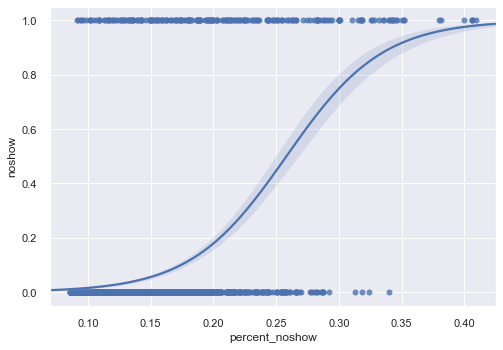

In [65]:
##training data
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x="percent_noshow", y="noshow",logistic=True, data=table)
fig = ax.get_figure()
fig.savefig("percent_noshow_logistic.png")

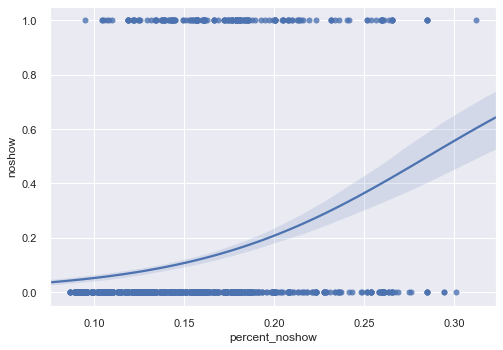

In [66]:
##test_data
percent_noshow = pd.DataFrame({'percent_noshow': y_pred_model_xgb_PT[:,1]})
test_table = pd.concat([X_test['PatientId'].reset_index(drop=True), y_test.reset_index(drop=True), percent_noshow.reset_index(drop=True)], axis=1)

test_logistic = sns.regplot(x="percent_noshow", y="noshow",logistic=True, data=test_table)
test_logistic = test_logistic.get_figure()
test_logistic.savefig("percent_noshow_logistic_test.png")

In [67]:
no_show_likely = test_table[test_table['percent_noshow']>0.18407562]
no_show_unlikely = test_table[test_table['percent_noshow']<0.18407562]
pd.crosstab(no_show_likely.noshow, no_show_likely.percent_noshow)

percent_noshow,0.184371,0.184452,0.184616,0.185175,0.185484,0.185565,0.185861,0.186117,0.186205,0.186929,...,0.265392,0.265434,0.266877,0.268834,0.274672,0.276007,0.284726,0.294488,0.300806,0.311949
noshow,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,9,3,1,8,1,10,...,5,0,1,1,1,1,4,2,1,0
1,1,1,1,0,5,0,0,1,0,0,...,4,1,0,0,0,0,4,0,0,1


In [72]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

gap = minmax(test_table.percent_noshow)
step_size = (gap[1]-gap[0])/50

cutoffs = np.arange(gap[0], gap[1], step_size)
cutoffs

array([0.08664061, 0.09114677, 0.09565293, 0.10015909, 0.10466525,
       0.10917141, 0.11367757, 0.11818373, 0.12268988, 0.12719604,
       0.1317022 , 0.13620836, 0.14071452, 0.14522068, 0.14972684,
       0.154233  , 0.15873916, 0.16324532, 0.16775148, 0.17225763,
       0.17676379, 0.18126995, 0.18577611, 0.19028227, 0.19478843,
       0.19929459, 0.20380075, 0.20830691, 0.21281307, 0.21731923,
       0.22182539, 0.22633154, 0.2308377 , 0.23534386, 0.23985002,
       0.24435618, 0.24886234, 0.2533685 , 0.25787466, 0.26238082,
       0.26688698, 0.27139314, 0.27589929, 0.28040545, 0.28491161,
       0.28941777, 0.29392393, 0.29843009, 0.30293625, 0.30744241,
       0.31194857])

In [73]:
no_show_unlikely[no_show_unlikely.noshow ==0].shape[0] /no_show_unlikely.shape[0]


0.9007731958762887

In [74]:
no_show_likely[no_show_likely.noshow ==1].shape[0] /no_show_likely.shape[0]

0.26744186046511625

In [75]:
no_show_precision = []
for i in cutoffs:
    no_show_likely = test_table[test_table['percent_noshow']>i]
    no_show_unlikely = test_table[test_table['percent_noshow']<i]
    precision = no_show_likely[no_show_likely.noshow ==1].shape[0] /no_show_likely.shape[0]
    percentage = (i-gap[0])/(gap[1]-gap[0])*100
    proportion = no_show_likely.shape[0] / test_table.shape[0]
    total = no_show_likely.shape[0]
    data = [percentage, precision, proportion, total]
    no_show_precision.append(data)



    
    

ZeroDivisionError: division by zero

In [76]:
test_table.shape[0]

1810

In [77]:
no_show_precision = pd.DataFrame(no_show_precision, columns = ['percentile', 'precision', 'proportion', 'total'])
no_show_precision[no_show_precision['percentile']>70]

,percentile,precision,proportion,total
36,72.0,0.328571,0.038674,70
37,74.0,0.328125,0.035359,64
38,76.0,0.339286,0.030939,56
39,78.0,0.366667,0.016575,30
40,80.0,0.333333,0.008287,15
41,82.0,0.357143,0.007735,14
42,84.0,0.384615,0.007182,13
43,86.0,0.416667,0.006630,12
44,88.0,0.250000,0.002210,4
45,90.0,0.250000,0.002210,4


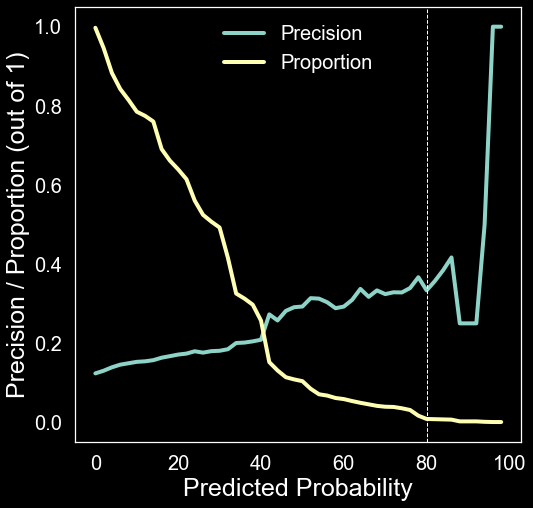

In [78]:
from matplotlib import pyplot

plt.style.use('dark_background') # this turns the whole figure (and following figures) into dark mode
# retrieve performance metrics
x_axis = no_show_precision['percentile']
# plot log loss
fig, ax = pyplot.subplots(figsize=(8,8))



ax.plot(x_axis, no_show_precision['precision'], label='Precision', lw=4)
ax.plot(x_axis, no_show_precision['proportion'], label='Proportion', lw=4)
ax.legend(prop={'size': 15})
plt.axvline(80, color='white', linestyle='--', lw =1)
pyplot.ylabel('Precision / Proportion (out of 1)', size=25)
#pyplot.title('Tradeoffs for Predicted Probablity Threshold', size=30)
pyplot.xlabel('Predicted Probability', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Hide grid lines
ax.grid(False)

plt.legend(prop={'size': 20})
pyplot.show()
fig.savefig("data/Tradeoffs.png", transparent=True)

In [80]:
# #storing the pickled model. 
# import pickle
# ##pickle model, code from Lindsay
# ##My model is called 'rf' (as you see above)- whatever you called your model, substitute that in for 'rf', below.
# ##Don't change anything else unless you really want to.
with open('insightMVP_model_weather_postFT.pkl', 'wb') as fid:
    pickle.dump(model_xgb_PT, fid,2)  


In [1069]:
import pickle
##pickle model, code from Lindsay
##My model is called 'rf' (as you see above)- whatever you called your model, substitute that in for 'rf', below.
##Don't change anything else unless you really want to.

#with 1 max depth
#with open('insightMVP_model_simple.pkl', 'wb') as fid:
    
with open('insightMVP_model_2depth.pkl', 'wb') as fid:
    pickle.dump(model_xgb_PT, fid,2)  

In [ ]:

# Load the model from disk
loaded_model = pickle.load(open('insightMVP_model.pkl', 'rb'))



y_pred_model_xgb = loaded_model.predict_proba(X_test)

print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))

In [1070]:
table

,PatientId,noshow,percent_noshow
0,9608,0,0.044785
1,9393,0,0.044785
2,9200,0,0.044785
3,8562,0,0.047990
4,9961,0,0.044785
...,...,...,...
3656,7685,0,0.139150
3657,4515,0,0.139150
3658,6830,0,0.155550
3659,1390,1,0.139150


In [ ]:
def highlight_greaterthan(s,threshold,column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]


style1 = table.style.apply(highlight_greaterthan,threshold=0.15,column=['percent_noshow'], axis=1)
df_html = style1.render()
df_html

In [ ]:
table.style.apply(highlight_greaterthan,threshold=0.15,column=['percent_noshow'], axis=1).head()

### EDA Figure

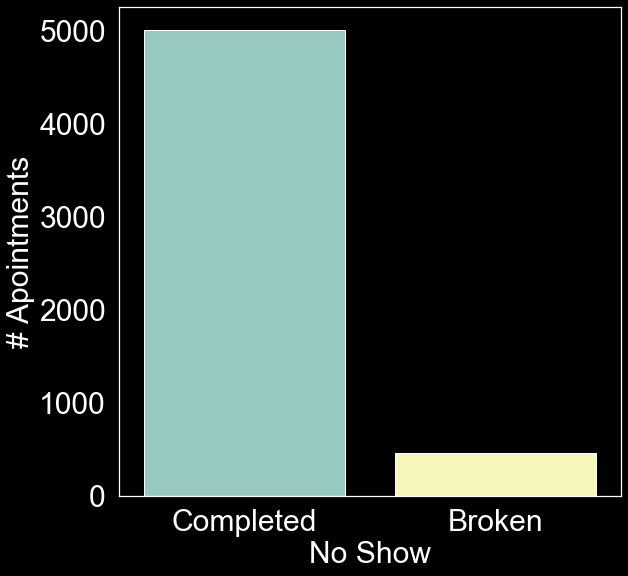

In [73]:
import seaborn as sb
import matplotlib as mlb
plt.style.use('dark_background') # this turns the whole figure (and following figures) into dark mode
# retrieve performance metrics
# plot log loss
fig, ax = pyplot.subplots(figsize=(9,9))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Hide grid lines
ax.grid(False)






sb.set(style="whitegrid")
ax = sb.countplot(x="noshow",data=y,  palette="Set3")
ax.set_xticklabels(labels = ['Completed','Broken'])
plt.xlabel('No Show', size =30)
plt.ylabel('# Apointments', size =30)

fig = ax.get_figure()
fig.savefig("data/noshow.png", transparent = True)

In [53]:
X.head()

,noshow
AppointmentId,
319,0
1526,0
4249,0
42,0
1942,0
